
# **NLP Processing of Drug Interactions using StanfordNLP**

---
 This Jupyter notebook demonstrates the process of 
  extracting relevant information from drug interaction events using the StanfordNLP library.

**The code provided**

 * implements a pipeline that takes a list of drug interactions 
 * performs NLP-based analysis to extract 
    1. the mechanism
    2. action
    3. drug information.
---



## 1. Install Used Library's 


In [2]:
import numpy as np

## 2. Extract dependency relations

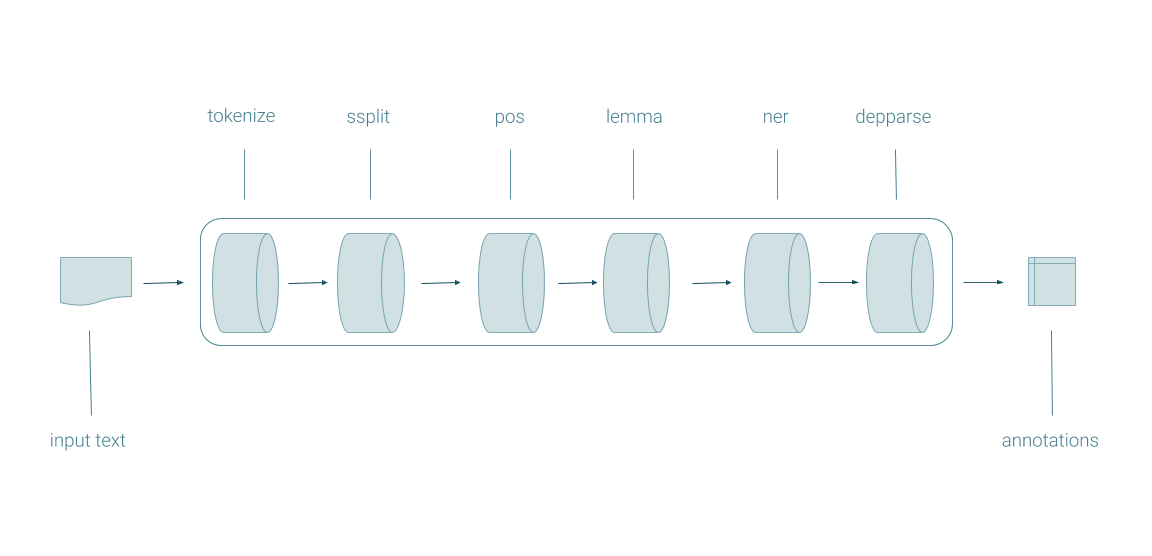




* **Tokenize** --> turning text into tokens
* **ssplit** --> Sentence splitting is the process of dividing text into sentences
* **pos** --> apply part of speech tags to the input text [Tags_Cheet_Sheat](https://www.google.com/url?sa=i&url=https%3A%2F%2Fm-clark.github.io%2Ftext-analysis-with-R%2Fpart-of-speech-tagging.html&psig=AOvVaw3ObhZmEaWNOhAx29ssFcKR&ust=1685401013530000&source=images&cd=vfe&ved=0CBEQjRxqFwoTCIiSzpzAl_8CFQAAAAAdAAAAABAQ)
* **lemma** --> maps a word to its lemma (dictionary form)
* **ner** --> Recognizes named entities (person and company names, etc.) in text
* **depparse** --> Provides a fast syntactic dependency parser


In [3]:
def processDependency(event):
    """
    Process the dependency relations of an event using StanfordNLP.
    Returns the dependency relations.
    """
    nlp = stanfordnlp.Pipeline()
    doc = nlp(event)
    return doc.sentences[0].words

In [4]:
processDependency("I Said 'Hello Osama Mohammed'")

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': 'C:\\Users\\Eng Osama Mo\\stanfordnlp_resources\\en_ewt_models\\en_ewt_tokenizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Cannot load model from C:\Users\Eng Osama Mo\stanfordnlp_resources\en_ewt_models\en_ewt_tokenizer.pt


AssertionError: 

## 3. Extract Information 

Given the dependency relations and a druglist, this function extracts the relevant information, including the action, drugA, and drugB involved in the interaction. It returns these lists along with the sonsNum and sons matrices.

In [ ]:
mechanism = []    # scenario for each Drug + Action
action = []       # root action 
drugA = []
drugB = []

In [ ]:
def extractInformation(dependency, druglist):
    """
    Extract relevant information from the dependency relations.
    Returns action, drugA, and drugB lists.
    """
    #  2D array where each row corresponds to a word, and each column
    sons = np.zeros((len(dependency), len(dependency)))
    #  1D NumPy array that keeps track of the number of sons (dependencies) for each word in the sentence 
    #  (eg. first row = 5, thus first 5 rows in sons are for first sentence)
    sonsNum = np.zeros(len(dependency))
    #  identify whether a word should be added to the drugA or drugB list. True => drugB, False => drugA
    flag = False
    count = 0

    for j in dependency:
        if j.dependency_relation == 'root':
            root = int(j.index)
            action.append(j.lemma)
        if j.text in druglist:
            if count < 2:
                if flag:
                    drugB.append(j.text)
                    count += 1
                else:
                    drugA.append(j.text)
                    flag = True
                    count += 1
        sonsNum[j.governor - 1] += 1
        sons[j.governor - 1, int(sonsNum[j.governor - 1] - 1)] = int(j.index)
    
    return sons,sonsNum,  root

In [ ]:
def addMechanism(node, sonsNum, sons, dependency, drugA, drugB, i):
    """
    Recursive function to add mechanism nodes to the queue based on dependency relations.
    """
    quene = []
    if int(sonsNum[int(node-1)]) == 0:
        return quene
    else:
        for k in sons[node-1]:
            if int(k) == 0:
                break
            if dependency[int(k - 1)].text == drugA[i] or dependency[int(k - 1)].text == drugB[i]:
                continue
            quene.append(int(k))
            quene.extend(addMechanism(int(k), sonsNum, sons, dependency, drugA, drugB, i))
    return quene

## 4. Main Function of Notebook 
It takes a druglist and a dataframe containing interaction events as input. This function processes the interaction events using StanfordNLP, extracts relevant information, and returns the mechanism, action, drugA, and drugB lists.

In [ ]:
def NLPProcess(druglist, df_interaction):
    """
    Process the interaction events using StanfordNLP and extract relevant information.
    """
    event = df_interaction['interaction']
    
    for i in range(len(event)):
        dependency = processDependency(event[i])
        sons,sonsNum,  root = extractInformation(dependency, druglist)
        
        quene = []
        for j in range(int(sonsNum[root-1])):
            if dependency[int(sons[root-1, j] - 1)].dependency_relation == 'obj' or dependency[int(sons[root-1, j] - 1)].dependency_relation == 'nsubj:pass':
                quene.append(int(sons[root-1, j]))
                break
        
        quene = addMechanism(quene[0], sonsNum, sons, dependency, drugA[i], drugB[i], i)
        quene.sort()
        mechanism_i = " ".join(dependency[j - 1].text for j in quene)
        
        if mechanism_i == "the fluid retaining activities":
            mechanism_i = "the fluid"
        if mechanism_i == "atrioventricular blocking ( AV block )":
            mechanism_i = "the atrioventricular blocking ( AV block ) activities increase"
        

    return mechanism, action, drugA, drugB

---